## 0. 문제 기획 및 설계

앞으로 수행할 태스크는 뉴스 요약문 생성하기로 NLP task중에서 문장 요약에 해당합니다.

문장요약을 하는 방법으로는 추출적 요약과 추상적 요약으로 총 2가지 방법이 존재하는데, 추출적 요약은 전체 문장에서 핵심 문장을 추출하는 방식으로 추출된 문장이 약간 어색할 수 있습니다.  
추상적 요약은 언어모델을 사용하여 문장을 생성하는 방식으로 요약된 문장이 좀 더 자연스럽지만 요구되는 데이터의 양이 많습니다.

해당 노트북에서 수행할 방법은 seq2seq모델을 사용한 추상적 문장 요약 방식을 수행하겠습니다.

## 1. 필요한 패키지 불러오기

In [1]:
import urllib.request
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant
import urllib.request
from collections import defaultdict

from gensim.models import KeyedVectors
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


문장을 요약할 데이터는 영문의 뉴스 데이터로 기사 원문과 짧게 요약된 headlines로 구성된 데이터 입니다.

영문 데이터이기 때문에 nltk패키지에서 불용어로 사용되는 단어를 제거하기 위해서 불용어 사전을 가져오겠습니다.

## 2. 데이터 불러오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(f"데이터 개수 : {data.shape[0]}")
print(f"변수 개수 : {data.shape[1]}")
data.head()

데이터 개수 : 98401
변수 개수 : 2


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


불러온 데이터의 형태는 위와 같습니다.

gesim패키지에서 사전에 학습이 완료된 임베딩 벡터를 불러와서 전이학습으로 사용하겠습니다.

In [3]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
vector = word2vec['my']
vector.shape     

(300,)

![image](https://user-images.githubusercontent.com/51338268/139614008-1f279c33-403a-4956-bce5-b4bcbef59589.png)
해당 오류가 발생하면 [링크](https://iambeginnerdeveloper.tistory.com/41)를 참고하여 gesim의 패키지 버전을 다운그레이드 시킵니다.  

!pip install --upgrade gensim==3.8.3

사전학습된 임베딩 벡터는 구글 뉴스 데이터들로 차원의 수는 300개인 벡터입니다. 

벡터파일의 크기가 압축전에는 1.5GB이고 압축을 해제하면 3GB가 넘기 때문에 해당 repository에는 넣지 않고 다운 받은 링크를 드리겠습니다.
- https://github.com/3Top/word2vec-api

## 3. 데이터 전처리 및 시각화

#### 결측값 확인

In [4]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 중복 데이터 제거

In [5]:
print(f"데이터 중복 제거 전 개수 : {data.shape[0]}")
data = data.drop_duplicates(keep="first")
print(f"데이터 중복 제거 후 개수 : {data.shape[0]}")

데이터 중복 제거 전 개수 : 98401
데이터 중복 제거 후 개수 : 98379


#### 텍스트 정규화

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어 제거

In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 텍스트 전처리 함수 적용

In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords=True):
    texts = []
    for s in tqdm(sentences):
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

In [10]:
clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.

100%|██████████| 24595/24595 [07:30<00:00, 54.58it/s] 


451.3416886329651  seconds


100%|██████████| 24595/24595 [00:13<00:00, 1773.33it/s]


14.340054750442505  seconds


In [11]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 이상치 제거

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.0996452494943
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299606623364742


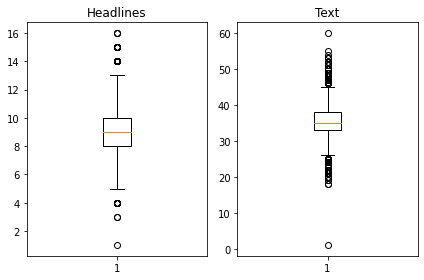

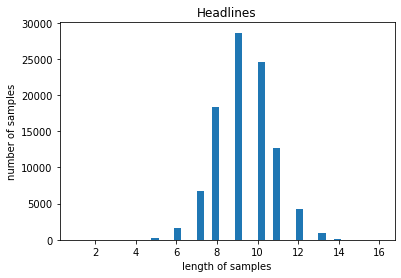

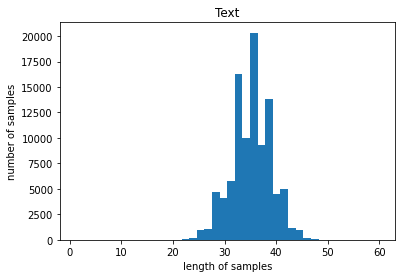

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

기사 원문의 단어 갯수와 headlines의 단어 갯수를 박스플랏으로 시각화한 결과 이상점으로 판단되는 원이 발생한다는 것을 알게 되었습니다.  
이러한 이상점을 제거하기 위해서 IQR을 기준으로 이상치 데이터들은 제거해주도록 하겠습니다.

In [13]:
data["headlines_len"] = data["headlines"].apply(lambda x : len(x.split()))
data["text_len"] = data["text"].apply(lambda x : len(x.split()))

In [14]:
cols = ["headlines_len", "text_len"]
def remove_outlier(data, columns):
    describe = data[columns].describe()

    for col in columns:
        IQR = describe[col]["75%"] - describe[col]["25%"]
        lower_limit = int(describe[col]["25%"] - (1.5 * IQR))
        upper_limit = int(describe[col]["75%"] + (1.5 * IQR))
        data = data.loc[(data[col] >= lower_limit) & (data[col] <= upper_limit)]
    return data.reset_index(drop=True)

data = remove_outlier(data, cols)

텍스트의 최소 길이 : 25
텍스트의 최대 길이 : 45
텍스트의 평균 길이 : 35.09149570329704
요약의 최소 길이 : 5
요약의 최대 길이 : 13
요약의 평균 길이 : 9.290516526174551


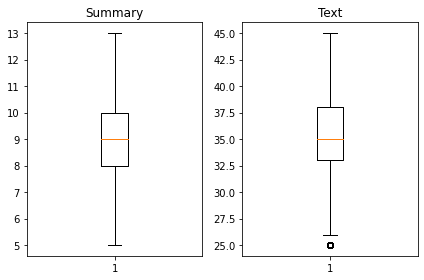

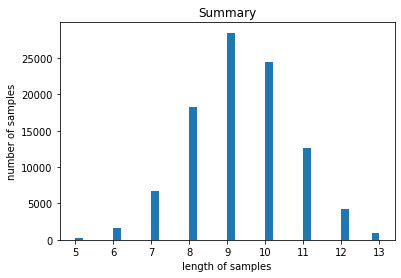

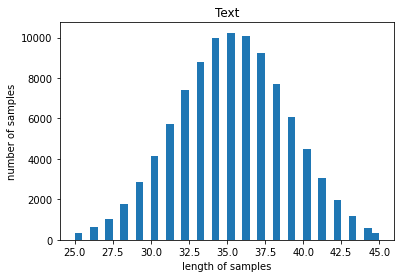

In [15]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

제거한 결과 이상점들이 크게 줄었고, 기사원문의 단어 갯수가 이상적인 정규분포를 그리게 되었습니다.

#### seq2seq모델에 맞는 입력 데이터로 변환

In [16]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : '<sos> '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' <eos>')
data.head()

,headlines,text,headlines_len,text_len,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,11,39,<sos> upgrad learner switches to career in ml ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,12,45,<sos> delhi techie wins free food from swiggy ...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,10,38,<sos> new zealand end rohit sharma led india m...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,9,34,<sos> aegon life iterm insurance plan helps cu...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,13,33,<sos> have known hirani for yrs what if metoo ...,have known hirani for yrs what if metoo claims...


In [17]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

현재 사용할 모델은 seq2seq모델이기 떄문에 문장의 시작부분을 알리는 sos토큰이 있는 decoder_input과 문장의 끝부분을 알리는 eos토큰이 있는 decoder_target을 만들어 주도록 하겠습니다.

#### 데이터 벡터화

In [18]:
encoder_token_data = encoder_input
encoder_word_num = defaultdict()

for encoder_token_one in tqdm(encoder_token_data):
    for encoder_word in encoder_token_one.split():
        if encoder_word in encoder_word_num:
            encoder_word_num[encoder_word] += encoder_token_one.count(encoder_word)
        else:
            encoder_word_num[encoder_word] = encoder_token_one.count(encoder_word)

encoder_word_num = sorted(dict(encoder_word_num).items(), key = lambda x: x[1], reverse = True)
encoder_words = [i for i, j in encoder_word_num]

encoder_word_index = dict()
encoder_index_word = dict()

encoder_word_index["<pad>"] = 0
encoder_word_index["<unk>"] = 1
encoder_word_index["<sos>"] = 2
encoder_word_index["<eos>"] = 3


encoder_index_word[0] = "<pad>"
encoder_index_word[1] = "<unk>"
encoder_index_word[2] = "<sos>"
encoder_index_word[3] = "<eos>"


for ind, word in enumerate(encoder_words):
    encoder_word_index[word] = ind + 4
    encoder_index_word[ind + 4] = word

100%|██████████| 97633/97633 [00:03<00:00, 30923.94it/s]


In [83]:
def encoder_text_sequence(token_data, maxlen, num_word, word_index):
    # 텍스트 데이터를 시퀀스 데이터로 변환
    encode_data = []
    dictionary = dict(list(word_index.items())[:num_word])
    for data in tqdm(token_data):
        tmp = []
        for word in data.split():
            if word in dictionary:
                tmp += [word_index[word]]
            else:
                tmp += [word_index["<unk>"]]
        encode_data += [tmp]
    # 시퀀스 데이터 일정한 길이로 패딩
    padded_data = pad_sequences(encode_data, value = word_index["<pad>"], padding = "post", maxlen = maxlen)
    return padded_data

encoder_maxlen = max(map(lambda x: len(x.split()), encoder_token_data))
encoder_vocab_size = len(encoder_word_index)
encoder_padded = encoder_text_sequence(encoder_token_data, encoder_maxlen, encoder_vocab_size, encoder_word_index)
print({f"인코더 문장 길이 : {encoder_padded.shape[1]}"})
print(f"단어의 개수 : {np.max(encoder_padded)}")
encoder_padded

100%|██████████| 97633/97633 [00:01<00:00, 59449.97it/s]


{'인코더 문장 길이 : 45'}
단어의 개수 : 75958


array([[27735,  5505,  8478, ...,     0,     0,     0],
       [ 4253,   188,  1254, ..., 21894, 11971,  2357],
       [   33,   727,   894, ...,     0,     0,     0],
       ...,
       [   89,    42,    33, ...,     0,     0,     0],
       [   33,   718,    54, ...,     0,     0,     0],
       [32505,  6289,   946, ...,     0,     0,     0]], dtype=int32)

encoder로 들어가는 기사원문을 벡터화시켜주었습니다.

In [40]:
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


decoder_token_data = decoder_input
decoder_word_num = defaultdict()

for decoder_token_one in tqdm(decoder_token_data):
    for decoder_word in decoder_token_one.split():
        if decoder_word in decoder_word_num:
            decoder_word_num[decoder_word] += decoder_token_one.count(decoder_word)
        else:
            decoder_word_num[decoder_word] = decoder_token_one.count(decoder_word)

decoder_word_num = sorted(dict(decoder_word_num).items(), key = lambda x: x[1], reverse = True)
decoder_words = [i for i, j in decoder_word_num]

decoder_word_index = dict()
decoder_index_word = dict()

decoder_word_index["<pad>"] = 0
decoder_word_index["<unk>"] = 1
decoder_word_index["<eos>"] = 2

decoder_index_word[0] = "<pad>"
decoder_index_word[1] = "<unk>"
decoder_index_word[2] = "<eos>"

for ind, word in enumerate(decoder_words):
    decoder_word_index[word] = ind + 3
    decoder_index_word[ind + 3] = word

100%|██████████| 97633/97633 [00:00<00:00, 135159.37it/s]


In [41]:
def decoder_text_sequence(token_data, maxlen, num_word, word_index):
    # 텍스트 데이터를 시퀀스 데이터로 변환
    encode_data = []
    dictionary = dict(list(word_index.items())[:num_word])
    for data in tqdm(token_data):
        tmp = []
        for word in data.split():
            if word in dictionary:
                tmp += [word_index[word]]
            else:
                tmp += [word_index["<unk>"]]
        encode_data += [tmp]
    # 시퀀스 데이터 일정한 길이로 패딩
    padded_data = pad_sequences(encode_data, value = word_index["<pad>"], padding = "post", maxlen = maxlen)
    return padded_data

decoder_vocab_size = len(decoder_word_index)

decoder_maxlen = max(map(lambda x: len(x.split()), decoder_token_data))
decoder_padded_input = np.array(decoder_text_sequence(decoder_input, decoder_maxlen, decoder_vocab_size, decoder_word_index))
print({f"디코더 인풋 문장 길이 : {decoder_padded_input.shape[1]}"})
print(f"단어의 개수 : {np.max(decoder_padded_input)}")
print(decoder_padded_input)

decoder_padded_target = np.array(decoder_text_sequence(decoder_target, decoder_maxlen, decoder_vocab_size, decoder_word_index))
print({f"디코더 아웃풋 문장 길이 : {decoder_padded_target.shape[1]}"})
print(f"단어의 개수 : {np.max(decoder_padded_target)}")
print(decoder_padded_target)

  0%|          | 0/97633 [00:00<?, ?it/s]

{'디코더 인풋 문장 길이 : 14'}
단어의 개수 : 32430
[[    3  5809  9914 ...  1103     0     0]
 [    3    29  3778 ...     6 11638     0]
 [    3    41  1276 ...     0     0     0]
 ...
 [    3    18 10426 ...     0     0     0]
 [    3  7893  8797 ...    41    80     0]
 [    3 21208 11397 ...     0     0     0]]


100%|██████████| 97633/97633 [00:00<00:00, 148531.27it/s]


{'디코더 아웃풋 문장 길이 : 14'}
단어의 개수 : 32430
[[ 5809  9914  9915 ...     2     0     0]
 [   29  3778   166 ... 11638     2     0]
 [   41  1276   346 ...     0     0     0]
 ...
 [   18 10426    63 ...     0     0     0]
 [ 7893  8797  3658 ...    80     2     0]
 [21208 11397  1871 ...     0     0     0]]


요약문에서 파생된 sos토큰이 있는 decoder_input과 eos토큰이 있는 decoder_target을 벡터화시켜주었습니다.

#### 데이터 순서 섞기 및 훈련, 테스트 데이터 분리

In [42]:
indices = np.arange(encoder_padded.shape[0])
np.random.seed(2022)
np.random.shuffle(indices)
print(indices)

[ 5743 30094 34396 ... 16557  1244 86909]


In [43]:
encoder_input = encoder_padded[indices]
decoder_input = decoder_padded_input[indices]
decoder_target = decoder_padded_target[indices]

In [44]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19526


In [45]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78107
훈련 레이블의 개수 : 78107
테스트 데이터의 개수 : 19526
테스트 레이블의 개수 : 19526


## 4. 뉴스 요약 모델 구축

In [114]:
hidden_size = 256
word_vector_dim = 300  # 사전학습된 임베딩 차원이 300이므로 고정
dropout_rate = 0.5

encoder_embedding_matrix = np.random.rand(encoder_vocab_size, word_vector_dim)


# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, encoder_vocab_size):
    if encoder_index_word[i] in word2vec:
        encoder_embedding_matrix[i] = word2vec[encoder_index_word[i]]
encoder_embedding_matrix.shape

(75959, 300)

In [115]:
decoder_embedding_matrix = np.random.rand(decoder_vocab_size, word_vector_dim)


# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, decoder_vocab_size):
    if decoder_index_word[i] in word2vec:
        decoder_embedding_matrix[i] = word2vec[decoder_index_word[i]]
decoder_embedding_matrix.shape

(32431, 300)

In [116]:
# 인코더
encoder_inputs = Input(shape=(encoder_maxlen,))

# 인코더의 임베딩 층
enc_emb = Embedding(encoder_vocab_size, 
                    word_vector_dim,
                    embeddings_initializer = Constant(encoder_embedding_matrix),
                    trainable = True
                   )(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = dropout_rate)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [117]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(decoder_vocab_size, 
                          word_vector_dim,
                          embeddings_initializer=Constant(decoder_embedding_matrix),
                          trainable = True
                         )
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = dropout_rate)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [118]:
# 디코더의 출력층
decoder_softmax_layer = Dense(decoder_vocab_size, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 45, 300)      22787700    input_8[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 45, 256), (N 570368      embedding_4[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [119]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [120]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(decoder_vocab_size, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 45, 300)      22787700    input_8[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 45, 256), (N 570368      embedding_4[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [121]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 220s 693ms/step - loss: 6.0976 - val_loss: 4.9306
Epoch 2/50
306/306 [==============================] - 210s 688ms/step - loss: 4.7238 - val_loss: 4.3784
Epoch 3/50
306/306 [==============================] - 210s 685ms/step - loss: 4.1716 - val_loss: 4.0875
Epoch 4/50
306/306 [==============================] - 210s 688ms/step - loss: 3.7916 - val_loss: 3.8917
Epoch 5/50
306/306 [==============================] - 211s 688ms/step - loss: 3.4872 - val_loss: 3.7629
Epoch 6/50
306/306 [==============================] - 211s 688ms/step - loss: 3.2302 - val_loss: 3.6787
Epoch 7/50
306/306 [==============================] - 210s 687ms/step - loss: 3.0231 - val_loss: 3.6179
Epoch 8/50
306/306 [==============================] - 211s 690ms/step - loss: 2.8402 - val_loss: 3.5789
Epoch 9/50
306/306 [==============================] - 210s 687ms/step - loss: 2.6832 - val_loss: 3.5534
Epoch 10/50
306/306 [==============================] - 211s 689m

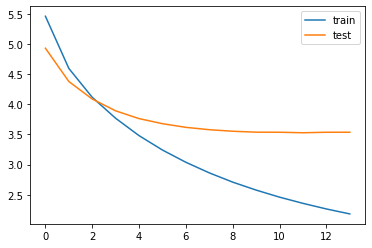

In [122]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [123]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [124]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(encoder_maxlen, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [125]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = encoder_word_index['<sos>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = decoder_index_word[sampled_token_index]

        if (sampled_token != '<eos>'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == '<eos>'  or len(decoded_sentence.split()) >= (decoder_maxlen-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        # e_out은 그대로여도 h,c가 바뀜에 따라서 결과가 달라짐
        e_h, e_c = h, c

    return decoded_sentence

## 5. 모델 평가

In [126]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + encoder_index_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!= decoder_word_index['<sos>']) and i!= decoder_word_index['<eos>']):
            temp = temp + decoder_index_word[i] + ' '
    return temp

In [127]:
for i in range(0, 5):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, encoder_maxlen)))
    print("\n")

원문 : hungary based researchers studying newly discovered solar system trappist observed several energetic flares star would make system less suitable hosting life seven earth like planets orbit host star much closer earth orbits sun unrealistically strong magnetic fields would needed shield atmosphere flares researchers said 
실제 요약 : new found solar system may be uninhabitable due to flaring 
예측 요약 :  astronomers find new universe of universe excitonium


원문 : busby babes name given manchester united footballers part club youth team early english first division matt busby management average age championship winning team eight players died munich air crash february 
실제 요약 : why were man utd players killed in crash called busby babes 
예측 요약 :  man utd player to win football club for football club


원문 : cancer patient pakistan urged external affairs minister sushma swaraj help visit india medical treatment woman claims paid advance treatment reportedly visa application rejected indian em

## 6. 추출적 요약과 비교해보기

In [128]:
from summa.summarizer import summarize
text ="The continued digitization of most every sector of society and industry means that an ever-growing volume of data will continue to be generated. The ability to gain insights from these vast datasets is one key to addressing an enormous array of issues — from identifying and treating diseases more effectively, to fighting cyber criminals, to helping organizations operate more effectively to boost the bottom line."

tmp = "<sos> " + preprocess_sentence(text)
tmp = encoder_text_sequence([tmp], encoder_maxlen, encoder_vocab_size, encoder_word_index)
tmp = decode_sequence(tmp.reshape(1, encoder_maxlen))
print(f"원문 : {text}")
print("\n")
print(f"추출적 요약 : {summarize(text, words = 15)}")
print("\n")
print(f"추상적 요약 : {tmp.strip()}")

100%|██████████| 1/1 [00:00<00:00, 4500.33it/s]


원문 : The continued digitization of most every sector of society and industry means that an ever-growing volume of data will continue to be generated. The ability to gain insights from these vast datasets is one key to addressing an enormous array of issues — from identifying and treating diseases more effectively, to fighting cyber criminals, to helping organizations operate more effectively to boost the bottom line.


추출적 요약 : The continued digitization of most every sector of society and industry means that an ever-growing volume of data will continue to be generated.


추상적 요약 : digital sector firms may be among global number study


## 7. 회고

- 처음에는 pre padding이 좋다고 생각하여 pre를 적용해보았지만 계속 <pad> 토큰만 반환하여 post padding 적용하여 학습이 진행되도록 만들었습니다.
    
- vocab_size를 8,000개나 10,000개 정도는 제대로 학습이 이루어지지 않았지만 모든 단어를 사용한다고 지정하자 그럴듯한 문장이 나오게 되었습니다.
- 기사원문의 중심단어들이 추상적 요약안에 포함되는 경우가 상당 수 보이지만 세부적인 내용의 요약을 한다고 보기는 어려운 수준입니다. 
- 이유는 모르겠지만 추상적 요약을 지원하는 summarize 함수가 전체의 단어 비율 0.5 이하이면 빈 리스트를 출력하고 단어갯수 15개 미만일때도 빈리스트를 반환합니다.
- seq2seq모델의 입력 데이터의 구조가 궁금하였는데 해당 EX node를 통하여 체험할 수 있었고, 좀 더 말이되고 원문의 내용을 잘 함축할 수 있는 모델을 만들어보고 싶어졌습니다.